In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


df = pd.read_csv(r'C:\Users\Aru\Downloads\NNDSS_Table_III._Tuberculosis_2018.csv')

original_reporting_area = 'Reporting area'
original_tuberculosis = 'Tuberculosis†, Cum 2018'

if original_reporting_area not in df.columns or original_tuberculosis not in df.columns:

    possible_reporting_cols = [col for col in df.columns if 'report' in col.lower()]
    possible_tb_cols = [col for col in df.columns if 'tuberc' in col.lower() or 'tb' in col.lower()]
    
    print(f"Could not find exact column names. Similar columns found:")
    print(f"Possible reporting area columns: {possible_reporting_cols}")
    print(f"Possible tuberculosis columns: {possible_tb_cols}")
    
   
    if possible_reporting_cols:
        original_reporting_area = possible_reporting_cols[0]
    if possible_tb_cols:
        original_tuberculosis = possible_tb_cols[0]
    
    print(f"Using: '{original_reporting_area}' and '{original_tuberculosis}'")


df = df.copy()
df.rename(columns={
    original_reporting_area: 'reporting_area',
    original_tuberculosis: 'tuberculosis_cum_2018'
}, inplace=True)


print("\nData summary:")
print(df[['reporting_area', 'tuberculosis_cum_2018']].describe())

print("\nMissing values:")
print(df[['reporting_area', 'tuberculosis_cum_2018']].isnull().sum())

plt.figure(figsize=(12, 8))
sns.boxplot(x='reporting_area', y='tuberculosis_cum_2018', data=df)
plt.xticks(rotation=90)
plt.title('Tuberculosis Cases by Reporting Area (2018)')
plt.tight_layout()
plt.savefig('tuberculosis_by_area_boxplot.png')
plt.close()


if df['tuberculosis_cum_2018'].dtype == 'object':
    print("\nConverting tuberculosis data to numeric format...")
    df['tuberculosis_cum_2018'] = pd.to_numeric(df['tuberculosis_cum_2018'], errors='coerce')
    print(f"After conversion, we have {df['tuberculosis_cum_2018'].isna().sum()} missing values")

if df['tuberculosis_cum_2018'].isna().any() or df['reporting_area'].isna().any():
    print("\nDropping rows with missing values...")
    orig_len = len(df)
    df = df.dropna(subset=['reporting_area', 'tuberculosis_cum_2018'])
    print(f"Dropped {orig_len - len(df)} rows with missing values")


print("\nFitting ANOVA model...")

anova_model = ols('tuberculosis_cum_2018 ~ C(reporting_area)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print("\nANOVA Results:")
print(anova_table)

ss_between = anova_table['sum_sq'][0]
ss_total = ss_between + anova_table['sum_sq'][1]  # Between + Within
eta_squared = ss_between / ss_total

print(f"\nEffect size (Eta squared): {eta_squared:.4f}")


if anova_table['PR(>F)'][0] < 0.05:
    print("\nANOVA shows significant differences. Performing Tukey's HSD post-hoc test.")

    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    tukey_results = pairwise_tukeyhsd(df['tuberculosis_cum_2018'], 
                                      df['reporting_area'],
                                      alpha=0.05)
    
    print("\nTukey's HSD Results:")
    print(tukey_results)
    
  
    plt.figure(figsize=(12, 8))
    tukey_results.plot_simultaneous()
    plt.tight_layout()
    plt.savefig('tukey_test_results.png')
    plt.close()
else:
    print("\nANOVA does not show significant differences between reporting areas.")


residuals = anova_model.resid
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.savefig('residuals_qq_plot.png')
plt.close()


plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.savefig('residuals_histogram.png')
plt.close()


print("\nPreparing for Levene's test...")
groups = []
for name, group in df.groupby('reporting_area'):
    if len(group) > 0:  # Ensure the group has values
        groups.append(group['tuberculosis_cum_2018'].values)

if len(groups) >= 2:
    try:
        levene_stat, levene_p = stats.levene(*groups)
    except Exception as e:
        print(f"Error in Levene's test: {e}")
        print("This may happen if groups have different sizes or contain NaN values.")
        levene_stat, levene_p = None, None
else:
    print("Not enough valid groups for Levene's test")
    levene_stat, levene_p = None, None

print("\nLevene's Test for Homogeneity of Variances:")
if levene_stat is not None and levene_p is not None:
    print(f"Statistic: {levene_stat:.4f}, p-value: {levene_p:.4f}")
    if levene_p < 0.05:
        print("Warning: Variances are not homogeneous (p < 0.05).")
        print("Consider transforming the data or using Welch's ANOVA.")
    else:
        print("Variances are homogeneous (p >= 0.05).")
    

    if levene_p < 0.05 and len(groups) >= 2:
        print("\nAttempting Welch's ANOVA:")
        try:
      
            try:
                welch_results = stats.f_oneway(*groups, welch=True)
                print(f"Welch's F-statistic: {welch_results[0]:.4f}, p-value: {welch_results[1]:.4f}")
            except TypeError:
                # For older scipy versions, we can't directly use Welch's ANOVA
                print("Your scipy version doesn't support the welch parameter for f_oneway.")
                print("Consider updating scipy or implementing Welch's ANOVA manually.")
        except Exception as e:
            print(f"Error performing Welch's ANOVA: {e}")
else:
    print("Levene's test could not be performed due to insufficient data or other issues.")


summary_stats = df.groupby('reporting_area')['tuberculosis_cum_2018'].agg(['count', 'mean', 'std', 'min', 'max'])
print("\nSummary Statistics by Reporting Area:")
print(summary_stats)


summary_stats.to_csv('tuberculosis_by_area_summary.csv')

print("\nAnalysis complete. Results and visualizations have been saved.")

#In order to ensure proper analysis, Kruskal Wallis was performed to account for unequal variances.


Data summary:
       tuberculosis_cum_2018
count             317.000000
mean              245.479495
std               783.910518
min                 1.000000
25%                15.000000
50%                51.000000
75%               163.000000
max              8062.000000

Missing values:
reporting_area            0
tuberculosis_cum_2018    18
dtype: int64

Dropping rows with missing values...
Dropped 18 rows with missing values

Fitting ANOVA model...

ANOVA Results:
                         sum_sq     df          F        PR(>F)
C(reporting_area)  1.481289e+08   64.0  12.663526  2.685825e-50
Residual           4.605807e+07  252.0        NaN           NaN

Effect size (Eta squared): 0.7628

ANOVA shows significant differences. Performing Tukey's HSD post-hoc test.


C:\Users\Aru\AppData\Local\Temp\ipykernel_8916\2758558133.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_between = anova_table['sum_sq'][0]
C:\Users\Aru\AppData\Local\Temp\ipykernel_8916\2758558133.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_total = ss_between + anova_table['sum_sq'][1]  # Between + Within
C:\Users\Aru\AppData\Local\Temp\ipykernel_8916\2758558133.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po


Tukey's HSD Results:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
    group1         group2      meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------------------
       ALABAMA         ALASKA      -30.2    1.0 -1157.5218  1097.1218  False
       ALABAMA    AMER. SAMOA      -64.6    1.0 -1260.3053  1131.1053  False
       ALABAMA        ARIZONA       21.8    1.0 -1105.5218  1149.1218  False
       ALABAMA       ARKANSAS      -26.8    1.0 -1154.1218  1100.5218  False
       ALABAMA       C.N.M.I.      -44.4    1.0 -1171.7218  1082.9218  False
       ALABAMA     CALIFORNIA     1161.8 0.0319    34.4782  2289.1218   True
       ALABAMA       COLORADO      -23.0    1.0 -1150.3218  1104.3218  False
       ALABAMA    CONNECTICUT      -33.2    1.0 -1160.5218  1094.1218  False
       ALABAMA       DELAWARE     -55.35    1.0 -1251.0553  1140.3553  False
       ALABAMA  DIST. OF COL.      -41.2    1.0 -1168.

<Figure size 1200x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:

import pandas as pd
from scipy import stats

# Load your data
df = pd.read_csv(r'C:\Users\Aru\Downloads\NNDSS_Table_III._Tuberculosis_2018.csv')

# Make sure the tuberculosis column is numeric
tb_col = 'Tuberculosis†, Cum 2018'
df['tuberculosis_cases'] = pd.to_numeric(df[tb_col], errors='coerce')

# Drop missing values
df = df.dropna(subset=['tuberculosis_cases'])

# Group by reporting area
groups = []
group_names = []

for name, group in df.groupby('Reporting area'):
    if len(group) > 0:  # Make sure the group has data
        groups.append(group['tuberculosis_cases'].values)
        group_names.append(name)

# Run Kruskal-Wallis test
if len(groups) >= 2:
    stat, p_value = stats.kruskal(*groups)
    
    print("Kruskal-Wallis Test Results:")
    print(f"H-statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Significant differences exist between reporting areas (p < 0.05)")
    else:
        print("No significant differences between reporting areas (p >= 0.05)")
else:
    print("Not enough groups with data for analysis")




Kruskal-Wallis Test Results:
H-statistic: 251.4814
p-value: 0.0000
Significant differences exist between reporting areas (p < 0.05)


Kruskal-Wallis Test Results:
H-statistic: 251.4814
p-value: 0.0000

Significant differences detected. Running Dunn's post-hoc test...

Significant pairwise differences (p < 0.05):
CALIFORNIA vs AMER. SAMOA: p-value = 0.0040
E.N. CENTRAL vs AMER. SAMOA: p-value = 0.0262
MID. ATLANTIC vs AMER. SAMOA: p-value = 0.0060
NEW YORK CITY vs AMER. SAMOA: p-value = 0.0288
PACIFIC vs AMER. SAMOA: p-value = 0.0028
S. ATLANTIC vs AMER. SAMOA: p-value = 0.0057
UNITED STATES vs AMER. SAMOA: p-value = 0.0011
NEBRASKA vs CALIFORNIA: p-value = 0.0273
NEW HAMPSHIRE vs CALIFORNIA: p-value = 0.0067
NORTH DAKOTA vs CALIFORNIA: p-value = 0.0365
SOUTH DAKOTA vs CALIFORNIA: p-value = 0.0217
WEST VIRGINIA vs CALIFORNIA: p-value = 0.0245
NEW HAMPSHIRE vs E.N. CENTRAL: p-value = 0.0467
PACIFIC vs IDAHO: p-value = 0.0446
UNITED STATES vs IDAHO: p-value = 0.0182
UNITED STATES vs KANSAS: p-value = 0.0222
UNITED STATES vs MAINE: p-value = 0.0207
NEBRASKA vs MID. ATLANTIC: p-value = 0.0403
NEW HAMPSHIRE vs MID. ATLANTI

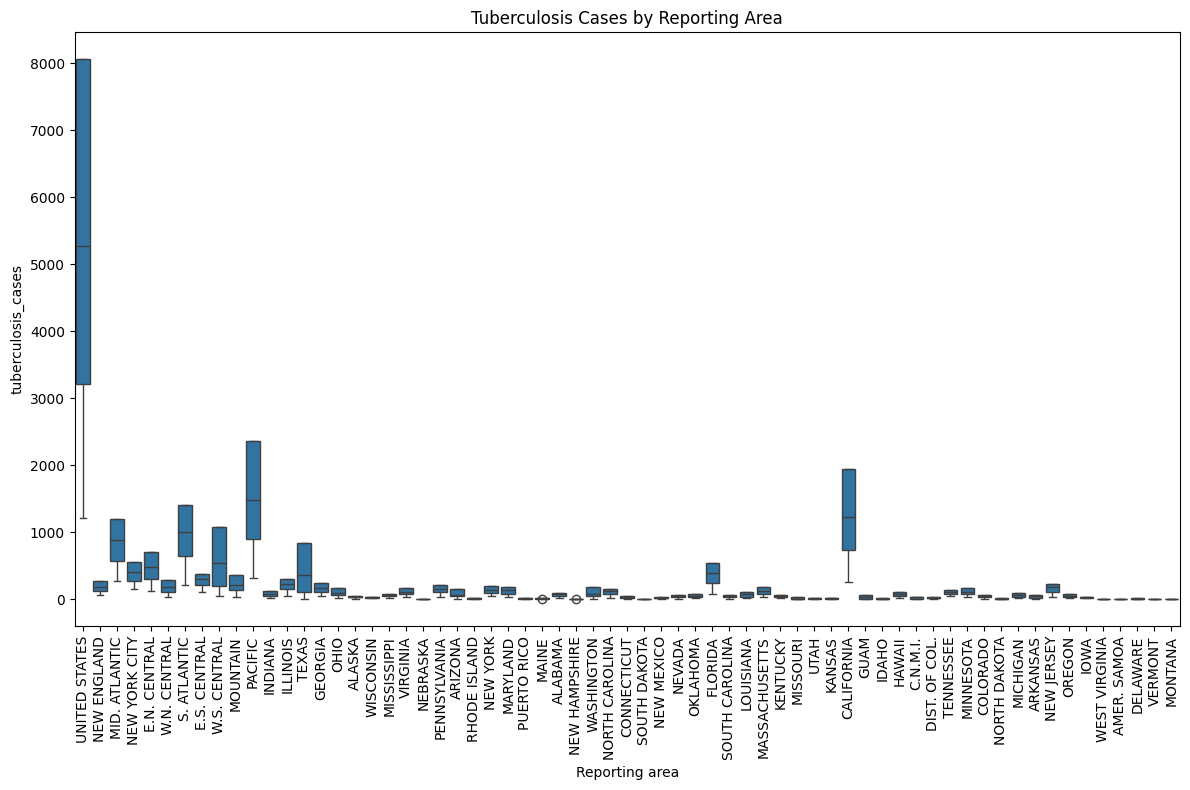

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scikit_posthocs import posthoc_dunn
import matplotlib.pyplot as plt
import seaborn as sns

tb_col = 'Tuberculosis†, Cum 2018'
df['tuberculosis_cases'] = pd.to_numeric(df[tb_col], errors='coerce')

# Drop missing values
df = df.dropna(subset=['tuberculosis_cases'])

# Run Kruskal-Wallis test
kruskal_result = stats.kruskal(*[group['tuberculosis_cases'].values 
                               for name, group in df.groupby('Reporting area')
                               if len(group) > 0])

print("Kruskal-Wallis Test Results:")
print(f"H-statistic: {kruskal_result[0]:.4f}")
print(f"p-value: {kruskal_result[1]:.4f}")

# If significant, perform Dunn's post-hoc test
if kruskal_result[1] < 0.05:
    print("\nSignificant differences detected. Running Dunn's post-hoc test...\n")
    
    # Create a dataframe for posthoc analysis
    posthoc_df = df[['Reporting area', 'tuberculosis_cases']].copy()
    
    # Run Dunn's test
    dunn_result = posthoc_dunn(posthoc_df, val_col='tuberculosis_cases', 
                              group_col='Reporting area', p_adjust='bonferroni')
    
    # Display significant pairwise differences
    print("Significant pairwise differences (p < 0.05):")
    significant_pairs = []
    
    for i in range(len(dunn_result.columns)):
        for j in range(i+1, len(dunn_result.index)):
            if dunn_result.iloc[j, i] < 0.05:
                area1 = dunn_result.index[j]
                area2 = dunn_result.columns[i]
                significant_pairs.append((area1, area2, dunn_result.iloc[j, i]))
    
    if significant_pairs:
        for area1, area2, p_val in significant_pairs:
            print(f"{area1} vs {area2}: p-value = {p_val:.4f}")
    else:
        print("No significant pairwise differences found after p-value adjustment")
    
    # Visualize the results
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Reporting area', y='tuberculosis_cases', data=posthoc_df)
    plt.xticks(rotation=90)
    plt.title('Tuberculosis Cases by Reporting Area')
    plt.tight_layout()
    plt.savefig('tuberculosis_by_area_boxplot.png')
    
    # Create a descriptive summary
    summary = posthoc_df.groupby('Reporting area')['tuberculosis_cases'].agg(['count', 'mean', 'median', 'std'])
    print("\nDescriptive statistics by reporting area:")
    print(summary)

    #This summary which uses the Kruskal Wallis test and Dunn's post-hoc shows that there exists a statistical significance
    #In tuberculosis cases between different reporting areas (states/regions)
    #The highest cases reported by state are California and Texas.
    #The questions which remain include: the impact of high state population, vulnerable populations such as undocumented,
    #poor, and homeless, and the effectiveness of state health programs in preventing and treating tuberculosis. 
    #Not all effect modifiers may exist in both states. 

